In [51]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
import os
import zipfile
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [52]:
with zipfile.ZipFile('archive.zip', 'r') as file:
    file.extractall()

In [53]:
def load_images_and_labels(directory, target_size=(64, 64)):
    images = []
    labels = []
    
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        
        if os.path.isdir(label_path):
            for image_file in os.listdir(label_path):
                image_path = os.path.join(label_path, image_file)
                
                image = Image.open(image_path)
                image = image.resize(target_size)
                image = np.array(image)
                
                #normalizing pixels
                image = image / 255.0
                
                images.append(image)
                labels.append(label)
    return np.array(images), np.array(labels)

dataset_directory = "Dog and Cat .png"

images, labels = load_images_and_labels(dataset_directory)

In [54]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

test_size = 0.2
val_size = 0.1

X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=(test_size + val_size), random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(val_size / (test_size + val_size)), random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (699, 64, 64, 3)
y_train shape: (699,)
X_val shape: (200, 64, 64, 3)
y_val shape: (200,)
X_test shape: (101, 64, 64, 3)
y_test shape: (101,)


In [55]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.75))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()
          

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 31, 31, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 6, 6, 128)        

In [56]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, mode='auto', restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Accuracy: {test_acc}')

Epoch 1/100
22/22 [==============================] - 4s 95ms/step - loss: 0.8299 - accuracy: 0.5393 - val_loss: 0.6896 - val_accuracy: 0.5150
Epoch 2/100
22/22 [==============================] - 2s 71ms/step - loss: 0.7076 - accuracy: 0.6066 - val_loss: 0.6886 - val_accuracy: 0.5150
Epoch 3/100
22/22 [==============================] - 1s 63ms/step - loss: 0.6317 - accuracy: 0.6538 - val_loss: 0.6867 - val_accuracy: 0.5150
Epoch 4/100
22/22 [==============================] - 1s 67ms/step - loss: 0.6287 - accuracy: 0.6481 - val_loss: 0.6861 - val_accuracy: 0.5150
Epoch 5/100
22/22 [==============================] - 1s 59ms/step - loss: 0.5888 - accuracy: 0.7024 - val_loss: 0.6815 - val_accuracy: 0.5400
Epoch 6/100
22/22 [==============================] - 1s 53ms/step - loss: 0.5741 - accuracy: 0.6967 - val_loss: 0.6775 - val_accuracy: 0.5200
Epoch 7/100
22/22 [==============================] - 1s 54ms/step - loss: 0.5352 - accuracy: 0.7511 - val_loss: 0.6720 - val_accuracy: 0.5350
Epoch 

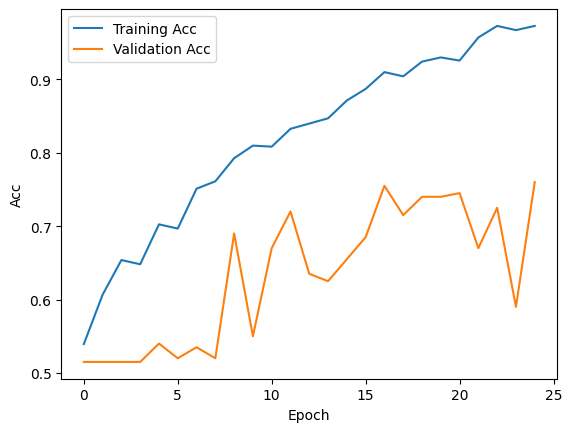

In [57]:
plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'], label='Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()
plt.show()

4/4 [==============================] - 0s 12ms/step
Example 1: Predicted Class: 0, True Class: 0
Example 2: Predicted Class: 0, True Class: 1
Example 3: Predicted Class: 0, True Class: 1
Example 4: Predicted Class: 1, True Class: 1
Example 5: Predicted Class: 0, True Class: 0


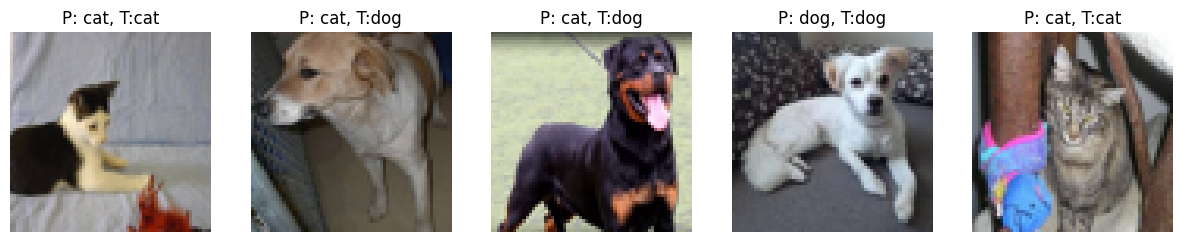

In [60]:
predictions = model.predict(X_test)

#threshold 0.5 convert them into binary classes
binary_predictions = (predictions > 0.5).astype(int)

num_images = min(5, len(X_test))

fig, axes = plt.subplots(1, num_images, figsize=(15,15))

for i in range(num_images):
    predicted_class = binary_predictions[i][0]
    true_class = y_test[i]
    
    print(f"Example {i+1}: Predicted Class: {predicted_class}, True Class: {true_class}")
    
    if predicted_class == 0:
        pred_class = 'cat'
    elif predicted_class == 1:
        pred_class = 'dog'   
    
    if true_class == 0:
        t_class = 'cat'
    elif true_class == 1:
        t_class = 'dog'
    
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"P: {pred_class}, T:{t_class}")
    axes[i].axis('off')